# Loading Model and Testing

In [28]:
! ls

Base_transformer.ipynb	Base_transformer.py  __pycache__  play_loader.py


In [29]:
import sys
import os
import tensorflow as tf
import numpy as np
import pandas as pd

from importlib import reload

from Base_transformer import TransformerPredictor 
from play_loader import load_play

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import custom_visualizer; reload(custom_visualizer)
from custom_visualizer import (
    extract_subset_from_dataloader,
    covert_sequences_to_df,
    extract_full_sequence,
    plot_trajectories,)     # <-- the file we made

In [30]:
# (optional) remind yourself of GPU & precision settings
print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [31]:
#WEIGHT_PATTERN = "weights/epoch_{:03d}-val{:.4f}.weights.h5"

WEIGHT_FILE = "../../weights/epoch_015-val0.0000.weights.h5"   # adjust as needed

model = TransformerPredictor(dtype_policy="mixed_float16")  # or omit arg for fp32
#model = TransformerPredictor()
model.load_weights(WEIGHT_FILE)

model.summary()  # sanity-check layer names/shapes match the notebook

Model: "NFL_Frame_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_11 (Cast)      │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj_xy (Dense)     │ (None, 100, 128)  │      6,016 │ cast_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_12 (Cast)      │ (None, 100, 46)   │          0 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_enc             │ (None, 100, 128)  │     12,800 │ proj_xy[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pad_mask            │ (None, 1, 1, 100) │          0 │ cast_12[0][0]     │
│ (PaddingMask)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 100, 128)  │    198,272 │ pos_enc[0][0],    │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 100, 128)  │    198,272 │ functional_4[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 100, 128)  │    198,272 │ functional_5[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 100, 128)  │    198,272 │ functional_6[0][… │
│ (Functional)        │                   │            │ pad_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_last_hidden  │ (None, 128)       │          0 │ functional_7[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_21 (Cast)      │ (None, 128)       │          0 │ lambda_last_hidd… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_xy (Dense)     │ (None, 46)        │      5,934 │ cast_21[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 817,838 (3.12 MB)

 Trainable params: 817,838 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
batch_size   = 8
timesteps_in = 80                    # < MAX_LEN just for demo
dummy_seq_batch = tf.random.uniform([batch_size, timesteps_in, 46])
dummy_seq = tf.random.uniform([timesteps_in, 46])

In [33]:
y_next = model.predict_next(dummy_seq)      # (8, 46)
print("Next-frame prediction shape:", y_next.shape)

Next-frame prediction shape: (46,)


In [34]:
n_future = 10
y_future = model.predict_autoregressive(dummy_seq, n_steps=n_future)  # (8, 10, 46)
print("Autoregressive rollout shape:", y_future.shape)

Autoregressive rollout shape: (10, 46)


# Vissualizing

In [35]:
DATASET_PATH = "../../processed_data/transformer_dataset"

def filter_split(split_num):
    def _filter(meta, x, y):
        return tf.equal(meta[2], split_num)
    return _filter

def drop_meta(meta, x, y):
    return x, y

raw_ds = tf.data.Dataset.load(DATASET_PATH)

test_ds  = (raw_ds
            .filter(filter_split(2))
            .shuffle(4096)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE))



In [36]:
play = next(iter(test_ds))            # a single batch (meta, x, y)

meta, x_ctx, y_next = play            # x_ctx: (1,100,46)

2025-04-30 23:20:46.638729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 170 of 4096
2025-04-30 23:20:59.229461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 330 of 4096
2025-04-30 23:21:36.150828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 929 of 4096
2025-04-30 23:21:52.382713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 1090 of 4096
2025-04-30 23:22:06.914400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 2906 of 4096
2025-04-30 23:22:11.581853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [37]:
n_future = 40
y_future = model.predict_autoregressive(x_ctx, n_steps=n_future)  # (1,100,46)

print("context shape:", x_ctx.shape)
print("future   shape:", y_future.shape)

context shape: (1, 100, 46)
future   shape: (1, 40, 46)


In [38]:
full_pred = tf.concat([x_ctx, y_future], axis=1)      # (1,200,46)

# If you **do** have the full ground-truth sequence for this play
# (not just y_next), put it here; otherwise set ground_truth_seq=None
ground_truth_seq = None            # ← replace when available

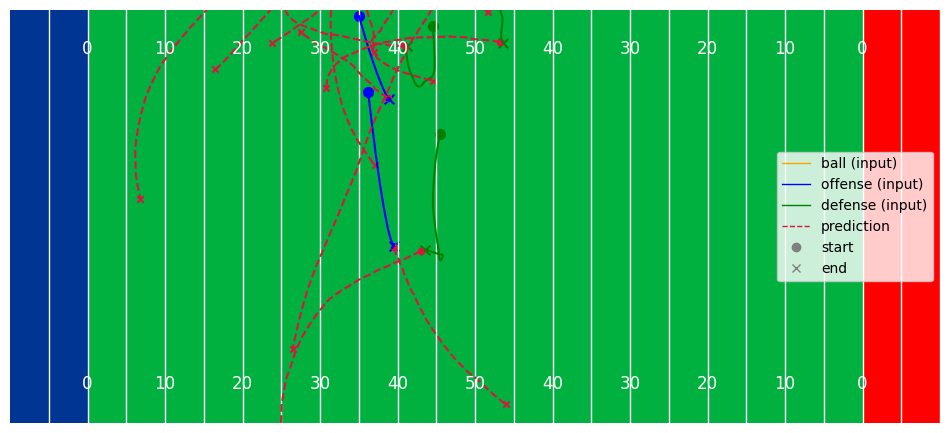

In [39]:
_ = plot_trajectories(
        sequence=x_ctx[0],                 # solid lines:   100-frame context
        offense='all', defense='all', include_ball=True,
        ground_truth_seq=(ground_truth_seq[:, 100:] if ground_truth_seq is not None else None),
        pred_seq=full_pred[:, 100:],       # dashed lines: model rollout
        gt_linestyle='-.', pred_linestyle='--',
        gt_color='limegreen', pred_color='crimson')

In [40]:
from play_loader import load_play

In [41]:
import pandas as pd

In [42]:
game_indexer = pd.read_parquet("../../processed_data/train_test_val.parquet")
df = pd.read_parquet("../../processed_data/model_input_2.parquet")

df = df.merge(game_indexer, how="left", on=["gameId", "playId"])

Selected gameId = 2022091103, playId = 1126
/mnt/c/Users/sebas/Desktop/LSE_2.0/MSc Statistics/ST456 Deep Learning/2025-projects-shallowlearning/code/Models


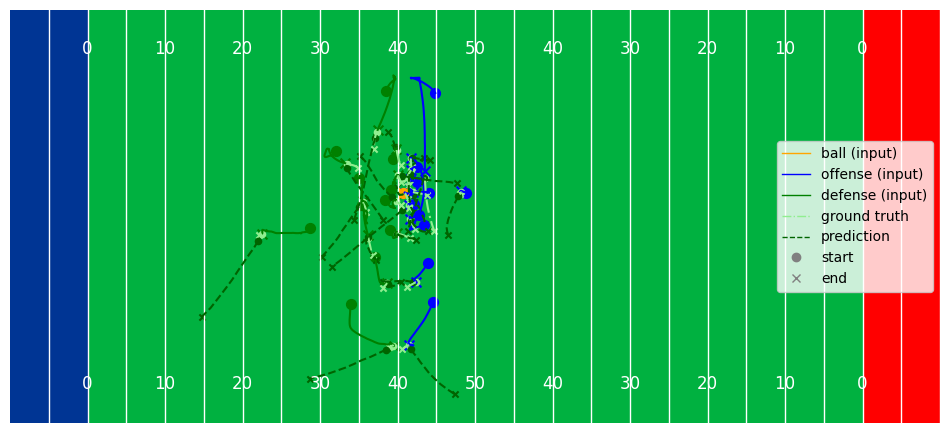

In [47]:
# Filter to test rows and pick one at random
N_STEPS = 10

row = (
    df
    .loc[df['split'] == "test", ['gameId', 'playId']]
    .sample(n=1) 
)

# Extract into Python variables
gameId = row['gameId'].iloc[0]
playId = row['playId'].iloc[0]

print(f"Selected gameId = {gameId}, playId = {playId}")

context_seq, gt_future = load_play(
    parquet_path="../../processed_data/model_input_2.parquet",
    game_id=gameId,
    play_id=playId,
    ctx_len=100,
    n_future=N_STEPS,
)

pred = model.predict_autoregressive(context_seq, n_steps=N_STEPS)

_ = custom_visualizer.plot_trajectories(
        sequence=context_seq[0],
        ground_truth_seq=gt_future,
        pred_seq=pred,
        offense='all', defense='all', include_ball=True)